In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
from matplotlib import pyplot as plt

from tqdm import tqdm

## 1. Линейная регрессия и SGD

Реализуем класс `SGDRegressor`. Спецификация:

* класс наследуется от `sklearn.base.BaseEstimator`
* конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию 10−3) и `n_iter` – число проходов по выборке (по умолчанию 10)
* также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
* Класс имеет методы `fit` и `predict`
* Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` нулями и в цикле с числом итераций `n_iter` обновляет веса, а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки и вектор весов `w` в предназначенные для этого списки.
* В конце метод `fit` создает переменную `w_opt`, в которой хранится тот вектор весов, при котором ошибка минимальна
* Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
* Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [2]:
class SGDRegressor(BaseEstimator):
    def __init__(self, n_iter=10, eta=1e-3, tolerance=1e-4, w0=None,):
        self.n_iter = n_iter
        self.eta = eta
        self.tolerance = tolerance
        self.w0 = w0
        self.w_opt = None
        self.weights_ = None
        self.mse_ = None
    
    def fit(self, X, y):
        # X = np.append(X, np.ones((X.shape[0], 1)), axis=1) # Добавляем столбец из единиц справа
        min_mse = np.inf
        self.mse_ = []
        self.weights_ = self.w0.copy() if self.w0 is not None else np.zeros(X.shape[1])
        
        for it in range(self.n_iter): 
            mse_tmp = self.calc_mse(X,y)
            self.mse_.append(mse_tmp)
                
            rand_index = np.random.randint(0, y.shape[0])            
            gradient = 1/X[rand_index].shape[0] *  X[rand_index].T.dot(
                                                                X[rand_index] @ self.weights_.T - y[rand_index].T
                                                                      )
            w_tmp = self.weights_ - self.eta * gradient
            
            if (mse_tmp - min_mse) < 1e-10:
                min_mse = mse_tmp
                self.w_opt = w_tmp
            
            if np.linalg.norm(w_tmp - self.weights_, 2) < self.tolerance:
                break
                
            self.weights_ = w_tmp
            
        return self
    
    def predict(self, X):
        if self.weights_ is None:
            raise Exception('Not trained yet')
            
        return X @ self.weights_.T
            
    def calc_mse(self, X, y):
        tmp = X @ self.weights_.T - y.T  
        
        return 1 / y.shape[0] * tmp @ tmp.T

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах):

In [3]:
data_demo = pd.read_csv('weights_heights.csv')
data_demo.head()

,Index,Height,Weight
0,1,65.78331,112.9925
1,2,71.51521,136.4873
2,3,69.39874,153.0269
3,4,68.21660,142.3354
4,5,67.78781,144.2971


In [4]:
data_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
Index     25000 non-null int64
Height    25000 non-null float64
Weight    25000 non-null float64
dtypes: float64(2), int64(1)
memory usage: 586.0 KB


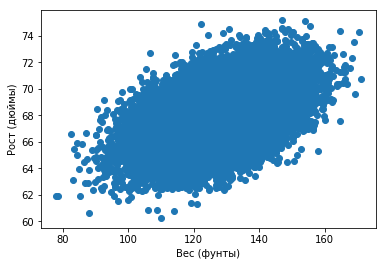

In [5]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [6]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

#X_train['const'] = 1
#X_test['const'] = 1

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_test_scaled = scaler.transform(X_test.reshape([X_test.shape[0], 1]))

Обучим созданный SGDRegressor на выборке (X_train_scaled, y_train). Параметры оставим по умолчанию:

In [8]:
def MSE(bar_y, y):
    return 1 / y.shape[0] * (bar_y - y) @ (bar_y - y).T

In [9]:
regressor = SGDRegressor()
regressor.fit(X_train_scaled, y_train)

print('MSE = %.4f' % MSE(regressor.predict(X_train_scaled), y_train))

MSE = 4626.5488


Изобразим на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска:

In [10]:
sns.set(style="darkgrid")

def DrawLoss(regressor, y, skip=0):
    title_tmp = f'Learning of linear regressor with SGD. Parameters: n_iter={regressor.n_iter}, eta={regressor.eta}'
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,8))
    
    ax.set_title(title_tmp)
    ax.set_xlabel('iterations')
    ax.set_ylabel('MSE')
    ax.plot([regressor.mse_[skip]] * skip + regressor.mse_[skip:])

    plt.show()

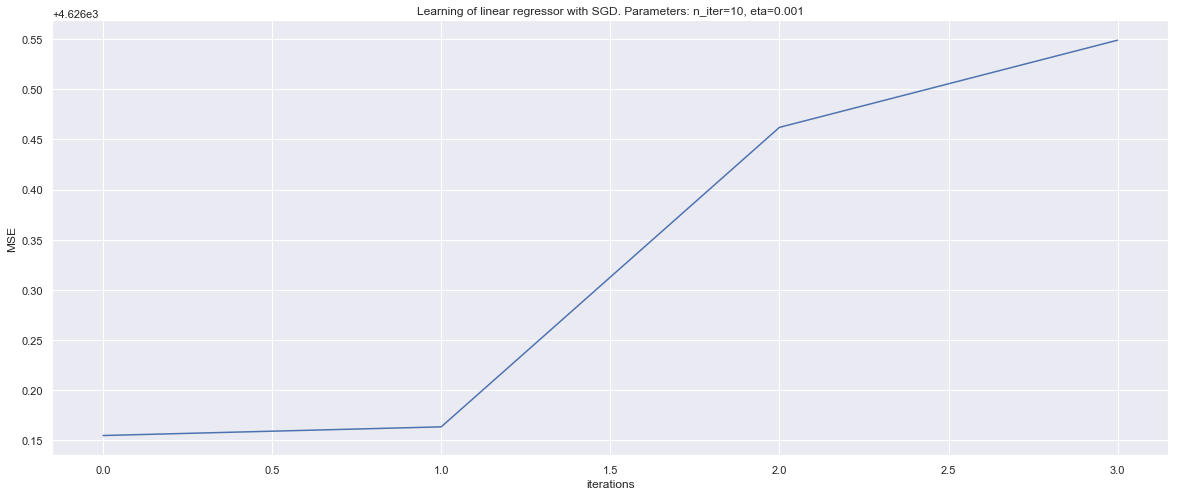

In [11]:
DrawLoss(regressor, np.array(y_train))

Выведем наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели:

In [12]:
print('Min MSE = %.4f' % min(regressor.mse_))
print('Weights when MSE is min: %.4f' % regressor.w_opt)

Min MSE = 4626.1549
Weights when MSE is min: -0.0046


Сделаем прогноз для отложенной выборки (X_test_scaled, y_test) и посмотрим на MSE:

In [13]:
print('MSE = %.4f' % MSE(regressor.predict(X_test_scaled), y_test))

MSE = 4628.7348


Теперь следаем то же самое, но с LinearRegression из sklearn.linear_model. Посчитаем MSE для отложенной выборки:

In [14]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [15]:
model = linear_model.LinearRegression().fit(X_train_scaled, y_train)

y_pred = model.predict(X_train_scaled)
print("Train MSE = %.4f" % mean_squared_error(y_train, y_pred))
y_pred = model.predict(X_test_scaled)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

Train MSE = 2.7151
Test MSE = 2.6708


---
---
---

## 2. Логистическая регрессия и SGD

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
Логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Формула 2.</font> Пересчитываем веса логистической регрессии при обучении стохастическим градиентным спуском:
 $$w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j )$$

Реализуем класс `SGDClassifier`. Спецификация:

- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и `C` – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` нулями и в цикле с числом итераций `n_iter` обновляет веса по выведенной формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_opt`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели, используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность *класса 1* меньше 0.5 <br>и 1 – в противном случае
- Во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) будем использовать написанную ниже функцию `sigma`

In [16]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [17]:
class SGDClassifier(BaseEstimator):
    def __init__(self, n_iter=10, eta=1e-3, C=None, tolerance=1e-4, w0=None):
        self.n_iter = n_iter
        self.eta = eta
        self.C=C
        self.tolerance = tolerance
        self.w0 = w0
        self.w_opt = None
        self.weights_ = None
        self.loss_ = None
    
    def fit(self, X, y):
        X = np.append(X, np.ones((X.shape[0], 1)), axis=1) # Добавляем столбец из единиц справа
        X[:, 0], X[:, 1:] = X[:, -1], X[:, 0:-1].copy() # Переставляем его в начало
        min_loss = np.inf
        self.loss_ = []
        self.weights_ = self.w0.copy() if self.w0 is not None else np.zeros(X.shape[1])
        
        for it in range(self.n_iter): 
            loss_tmp = self.calc_loss(X,y)
            self.loss_.append(loss_tmp)
                
            rand_index = np.random.randint(0, y.shape[0])            
            tmp = -y[rand_index].T * (X[rand_index].T @ self.weights_)
            
            # В формуле 2 ошибка: ни по какой из этих формул не вычисляется градиент
            gradient = self.C * y[rand_index] * X[rand_index] @ sigma(tmp).T - self.weights_[0]
            w_tmp = self.weights_ - self.eta * gradient
            
            if (loss_tmp - min_loss) < 1e-10:
                min_loss = loss_tmp
                self.w_opt = w_tmp
            
            if np.linalg.norm(w_tmp - self.weights_, 2) < self.tolerance:
                break
                
            self.weights_ = w_tmp
            
        return self
    
    def predict(self, X):
        if self.weights_ is None:
            raise Exception('Not trained yet')
        
        class_proba = predict_proba(self, X)
            
        return 1 if (0.5 - class_proba) <= 1e-14 else -1
    
    def predict_proba(self, X):
        X = np.append(X, np.ones((X.shape[0], 1)), axis=1) # Добавляем столбец из единиц справа
        X[:, 0], X[:, 1:] = X[:, -1], X[:, 0:-1].copy() # Переставляем его в начало
        
        return sigma(self.weights_.T @ X)
            
    def calc_loss(self, X, y):
        tmp = -y.T.dot(X @ self.weights_)
        
        return self.C * np.log1p( np.exp(tmp) ) + 1/2 * self.weights_.T @ self.weights_

Проверим `SGDClassifier` на данных UCI по раку молочной железы:

In [18]:
from sklearn.datasets import load_breast_cancer

In [19]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучим на масштибированной выборке `SGDClassifier` с параметрами `n_iter=3`, `eta=1e-3` и `C=1`:

In [22]:
def loss(bar_y, y):
    tmp = -y.dot(bar_y)
        
    return np.log1p( np.exp(tmp) ) # self.C * ... + 1/2 * self.weights_.T @ self.weights_

In [ ]:
classifier = SGDClassifier(n_iter=3, eta=1e-3, C=1)
classifier.fit(X_train_scaled, y_train)

print('Log loss = %.4f' % loss(classifier.predict(X_train_scaled), y_train))

> В формуле 2 ошибка: ни по какой из этих формул не вычисляется градиент.
<br> Пересчитать потом нужно будет заново все аналитические выкладки, пока хватит log-регрессий.

---
---
---

## 3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. Данные можно скачать [отсюда](https://drive.google.com/open?id=1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l).

In [23]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [24]:
reviews_train = load_files(".../aclImdb/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [25]:
reviews_test = load_files(".../aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак:

In [26]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 1min 20s, sys: 3.09 s, total: 1min 23s
Wall time: 1min 24s


In [27]:
X_train.shape, X_test.shape

((398, 30), (171, 30))

Чего-то пошло не так и размер выборки крайне ничтожный :/

In [28]:
y_train.shape, y_test.shape

((75000,), (25000,))

Обучим на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только с `random_state`=17) и посчитаем ROC AUC на тестовой выборке. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне:

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
model = linear_model.SGDClassifier(random_state=17).fit(X_train, y_train)

y_pred = model.predict(X_train)
print("Train MSE = %.4f" % mean_squared_error(y_train, y_pred))
y_pred = model.predict(X_test)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

>*Из-за несоответствующих размеров выборки, отладим модель позже..*

Перейдем к `sklearn`-реализации SGD-алгоритма. 
<br>Проведем 100 итераций SGD-логрегрессии (`random_state`=17) на той же выборке: